In [1]:
from pathlib import Path
import gzip
from glob import glob
import os
import shutil
import urllib.request as request
from contextlib import closing

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import xarray as xr
import numpy as np
import pandas as pd
import cartopy.feature as cfeature
from cartopy import crs as ccrs
from metpy.plots import USCOUNTIES, ctables
import cf2cdm
from datetime import datetime
from dateutil import tz

In [4]:
# Download files

spc_wind = pd.read_csv('https://www.spc.noaa.gov/climo/reports/yesterday_wind.csv')
spc_tornado = pd.read_csv('https://www.spc.noaa.gov/climo/reports/yesterday_torn.csv')
spc_hail = pd.read_csv('https://www.spc.noaa.gov/climo/reports/yesterday_hail.csv')

In [5]:
# Read in files and acquire data needed for plotting

BOTTOM_LAT = 23.5
TOP_LAT = 37
LEFT_LON = 360-92
RIGHT_LON = 360-75

LAT_SLICE = slice(BOTTOM_LAT, TOP_LAT)
LON_SLICE = slice(LEFT_LON, RIGHT_LON)

ds = xr.load_dataset(glob('data/MRMS_RotationTrack*.grib2')[0], engine='cfgrib',
                     backend_kwargs={'indexpath':''})
ds = ds.metpy.parse_cf()
ds = cf2cdm.translate_coords(ds, cf2cdm.CDS)

lats = ds.lat.sel(lat=LAT_SLICE)
lons = ds.lon.sel(lon=LON_SLICE)

mrms_values = ds.paramId_0.metpy.sel(lat=LAT_SLICE, lon=LON_SLICE).squeeze().metpy.unit_array

def convert_datetime(mrms_time):
    from_zone = tz.gettz('UTC')
    to_zone = tz.gettz('America/New York')
    utc_time = datetime.strptime(mrms_time, '%Y-%m-%dT%H:%M:%S').replace(tzinfo=from_zone)
    eastern = utc_time.astimezone(to_zone)
    date_time = datetime.strftime(eastern, '%a, %b %d, %Y %I:%M %p').lstrip('0').replace(' 0', ' ')
    return date_time

VALID_TIME = convert_datetime(str(ds.time.values).split('.')[0])

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


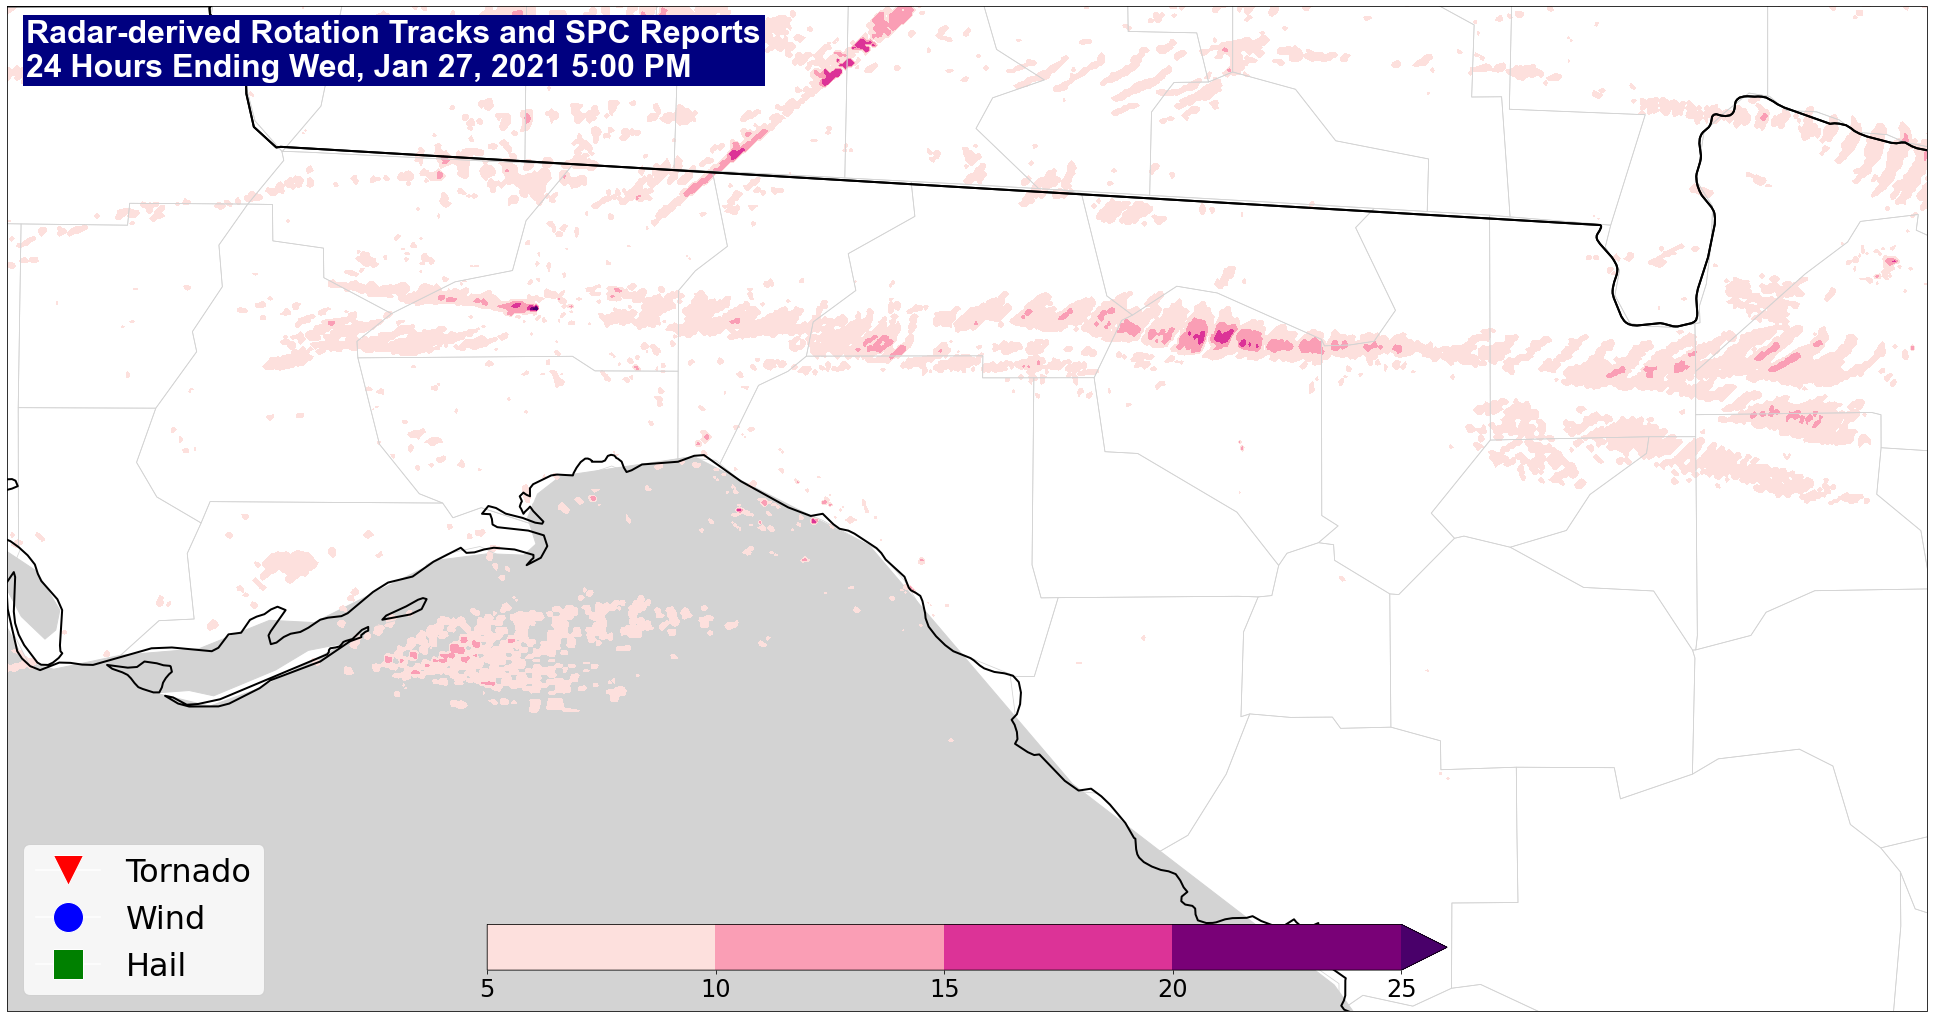

In [13]:
fig = plt.figure(figsize=(1920/72, 1080/72))
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.PlateCarree())

ax.add_feature(cfeature.OCEAN.with_scale('50m'), color='lightgray')
ax.add_feature(USCOUNTIES.with_scale('20m'), edgecolor='lightgray', linewidth=0.75)
ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=2.0)
ax.set_adjustable('datalim')
#ax.set_extent([-82, -79, 31, 36])
#ax.set_extent([-87, -80, 23.5, 32])
ax.set_extent([-84.0, -83.0, 29, 31])

#ax.set_extent([-84, -80, 34.1, 35.5])
#ax.set_extent([-83.5, -78.5, 33.5, 35.0])

range_rotation = [num for num in np.arange(5, 30, 5)]
contour = ax.contourf(lons, lats, mrms_values, range_rotation, cmap=plt.cm.RdPu, 
                      extend='max', transform=ccrs.PlateCarree())

cbar = plt.colorbar(contour, orientation='horizontal', pad=-0.08, shrink=0.5,)
cbar.ax.tick_params(labelsize='24')

# Plot SPC Reports
ax.scatter(spc_wind.Lon, spc_wind.Lat, transform=ccrs.PlateCarree(), marker='o', s=200, c='blue', zorder=3)
ax.scatter(spc_tornado.Lon, spc_tornado.Lat, transform=ccrs.PlateCarree(), marker='v', s=400, c='red', zorder=3)
ax.scatter(spc_hail.Lon, spc_hail.Lat, transform=ccrs.PlateCarree(), marker='s', s=(spc_hail.Size/10)**2, c='green', zorder=3)

legend_elements = [Line2D([0], [0], marker='v', color='w', label='Tornado',
                          markerfacecolor='red', markersize=30),
                   Line2D([0], [0], marker='o', color='w', label='Wind',
                          markerfacecolor='blue', markersize=30),
                   Line2D([0], [0], marker='s', color='w', label='Hail',
                          markerfacecolor='green', markersize=30)]

ax.legend(handles=legend_elements, loc='lower left', fontsize=32)

# Make the axis title
ax.set_title(f'Radar-derived Rotation Tracks and SPC Reports\n24 Hours Ending {VALID_TIME}', loc='left', 
             ha='left', va='center', fontsize=32, fontname='Arial',
             color='white', fontweight='bold', y=0.95, x=0.01,
             bbox=dict(facecolor='navy', alpha=1.0, edgecolor='none'))

# Plot cities
# cities = {
#     'Pensacola': [30.4213, -87.2169],
#     'Tallahassee': [30.4383, -84.2807],
#     'Gainesville': [29.6516, -82.3248],
#     'Tampa': [27.9506, -82.4572],
#     'Orlando': [28.5383, -81.3792],
#     'Ft Myers': [26.6406, -81.8723],
#     'Miami': [25.7617, -80.1918],
#     'Key West': [24.5551, -81.7800]
# }

# def plot_cities(lat, lon, city_name):
#     ax.text(lon, lat, city_name, fontsize=28, zorder=10, fontweight='bold', fontname='Arial', backgroundcolor='black',
#             color='white', ha='center', transform=ccrs.PlateCarree())

# for city in cities.keys():
#     plot_cities(cities[city][0], cities[city][1], city)

# Save and show figure
graphics_dir = Path('.') / '..' / '..' / 'graphics' / 'mrms'
plt.savefig(f'{graphics_dir}/rotation_past24hr.png', dpi=72)
plt.show()